In [ ]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

Problem-2)
Forecast the Airlines Passengers data set. Prepare a document for each model explaining

How many dummy variables you have created and RMSE value for each model. Finally which model you will use for Forecasting.

In [ ]:
#Data loading
from google.colab import files
uploaded=files.upload()

Saving Airlines+Data.xlsx to Airlines+Data (1).xlsx


In [ ]:
airlines=pd.read_excel('Airlines+Data.xlsx')
airlines

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


Basic & EDA

In [ ]:
airlines.shape

(96, 2)

In [ ]:
airlines.rename(columns = {'Month':'date','Passengers':'passengers'}, inplace = True)

In [ ]:
airlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        96 non-null     datetime64[ns]
 1   passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


Datatypes of all features are correct.

In [ ]:
airlines.nunique()

date          96
passengers    80
dtype: int64

In [ ]:
airlines.isna().sum()

date          0
passengers    0
dtype: int64

There are no null values in the given dataset.

In [ ]:
airlines.duplicated().value_counts()

False    96
dtype: int64

There are no duplicate records in the given dataset.

In [ ]:
airlines.describe().T

,count,mean,std,min,25%,50%,75%,max
passengers,96.0,213.708333,71.918216,104.0,156.0,200.0,264.75,413.0


In [ ]:
airlines.set_index('date',inplace=True)
airlines

,passengers
date,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121
...,...
2002-08-01,405
2002-09-01,355
2002-10-01,306


In [ ]:
upsampled_month = airlines['passengers']
upsampled_month = upsampled_month.resample('M').mean()
pd.set_option('display.max_rows', 10)
upsampled_month

date
1995-01-31    112.0
1995-02-28    118.0
1995-03-31    132.0
1995-04-30    129.0
1995-05-31    121.0
              ...  
2002-08-31    405.0
2002-09-30    355.0
2002-10-31    306.0
2002-11-30    271.0
2002-12-31    306.0
Freq: M, Name: passengers, Length: 96, dtype: float64

In [ ]:
interpolated_month = upsampled_month.interpolate(method='linear')
interpolated_month=pd.DataFrame(interpolated_month)
interpolated_month

,passengers
date,
1995-01-31,112.0
1995-02-28,118.0
1995-03-31,132.0
1995-04-30,129.0
1995-05-31,121.0
...,...
2002-08-31,405.0
2002-09-30,355.0
2002-10-31,306.0


In [ ]:
interpolated_month.reset_index(inplace=True)
interpolated_month['t'] = np.arange(1,len(interpolated_month)+1)
interpolated_month['t_squared'] = np.square(interpolated_month.t)
interpolated_month["month"] = interpolated_month.date.dt.strftime("%b") # month 
interpolated_month["year"] =pd.to_numeric( interpolated_month.date.dt.strftime("%Y")) # year
months = pd.get_dummies(interpolated_month['month'])
months = months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
airlines_upsp = pd.concat([interpolated_month,months],axis=1)
airlines_upsp['log_passengers'] = np.log(airlines_upsp['passengers'])
airlines_upsp

,date,passengers,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_passengers
0,1995-01-31,112.0,1,1,Jan,1995,1,0,0,0,0,0,0,0,0,0,0,0,4.718499
1,1995-02-28,118.0,2,4,Feb,1995,0,1,0,0,0,0,0,0,0,0,0,0,4.770685
2,1995-03-31,132.0,3,9,Mar,1995,0,0,1,0,0,0,0,0,0,0,0,0,4.882802
3,1995-04-30,129.0,4,16,Apr,1995,0,0,0,1,0,0,0,0,0,0,0,0,4.859812
4,1995-05-31,121.0,5,25,May,1995,0,0,0,0,1,0,0,0,0,0,0,0,4.795791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2002-08-31,405.0,92,8464,Aug,2002,0,0,0,0,0,0,0,1,0,0,0,0,6.003887
92,2002-09-30,355.0,93,8649,Sep,2002,0,0,0,0,0,0,0,0,1,0,0,0,5.872118
93,2002-10-31,306.0,94,8836,Oct,2002,0,0,0,0,0,0,0,0,0,1,0,0,5.723585
94,2002-11-30,271.0,95,9025,Nov,2002,0,0,0,0,0,0,0,0,0,0,1,0,5.602119


In [ ]:
airlines_upsp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            96 non-null     datetime64[ns]
 1   passengers      96 non-null     float64       
 2   t               96 non-null     int64         
 3   t_squared       96 non-null     int64         
 4   month           96 non-null     object        
 5   year            96 non-null     int64         
 6   Jan             96 non-null     uint8         
 7   Feb             96 non-null     uint8         
 8   Mar             96 non-null     uint8         
 9   Apr             96 non-null     uint8         
 10  May             96 non-null     uint8         
 11  Jun             96 non-null     uint8         
 12  Jul             96 non-null     uint8         
 13  Aug             96 non-null     uint8         
 14  Sep             96 non-null     uint8         
 15  Oct     

Visualizing Data Points

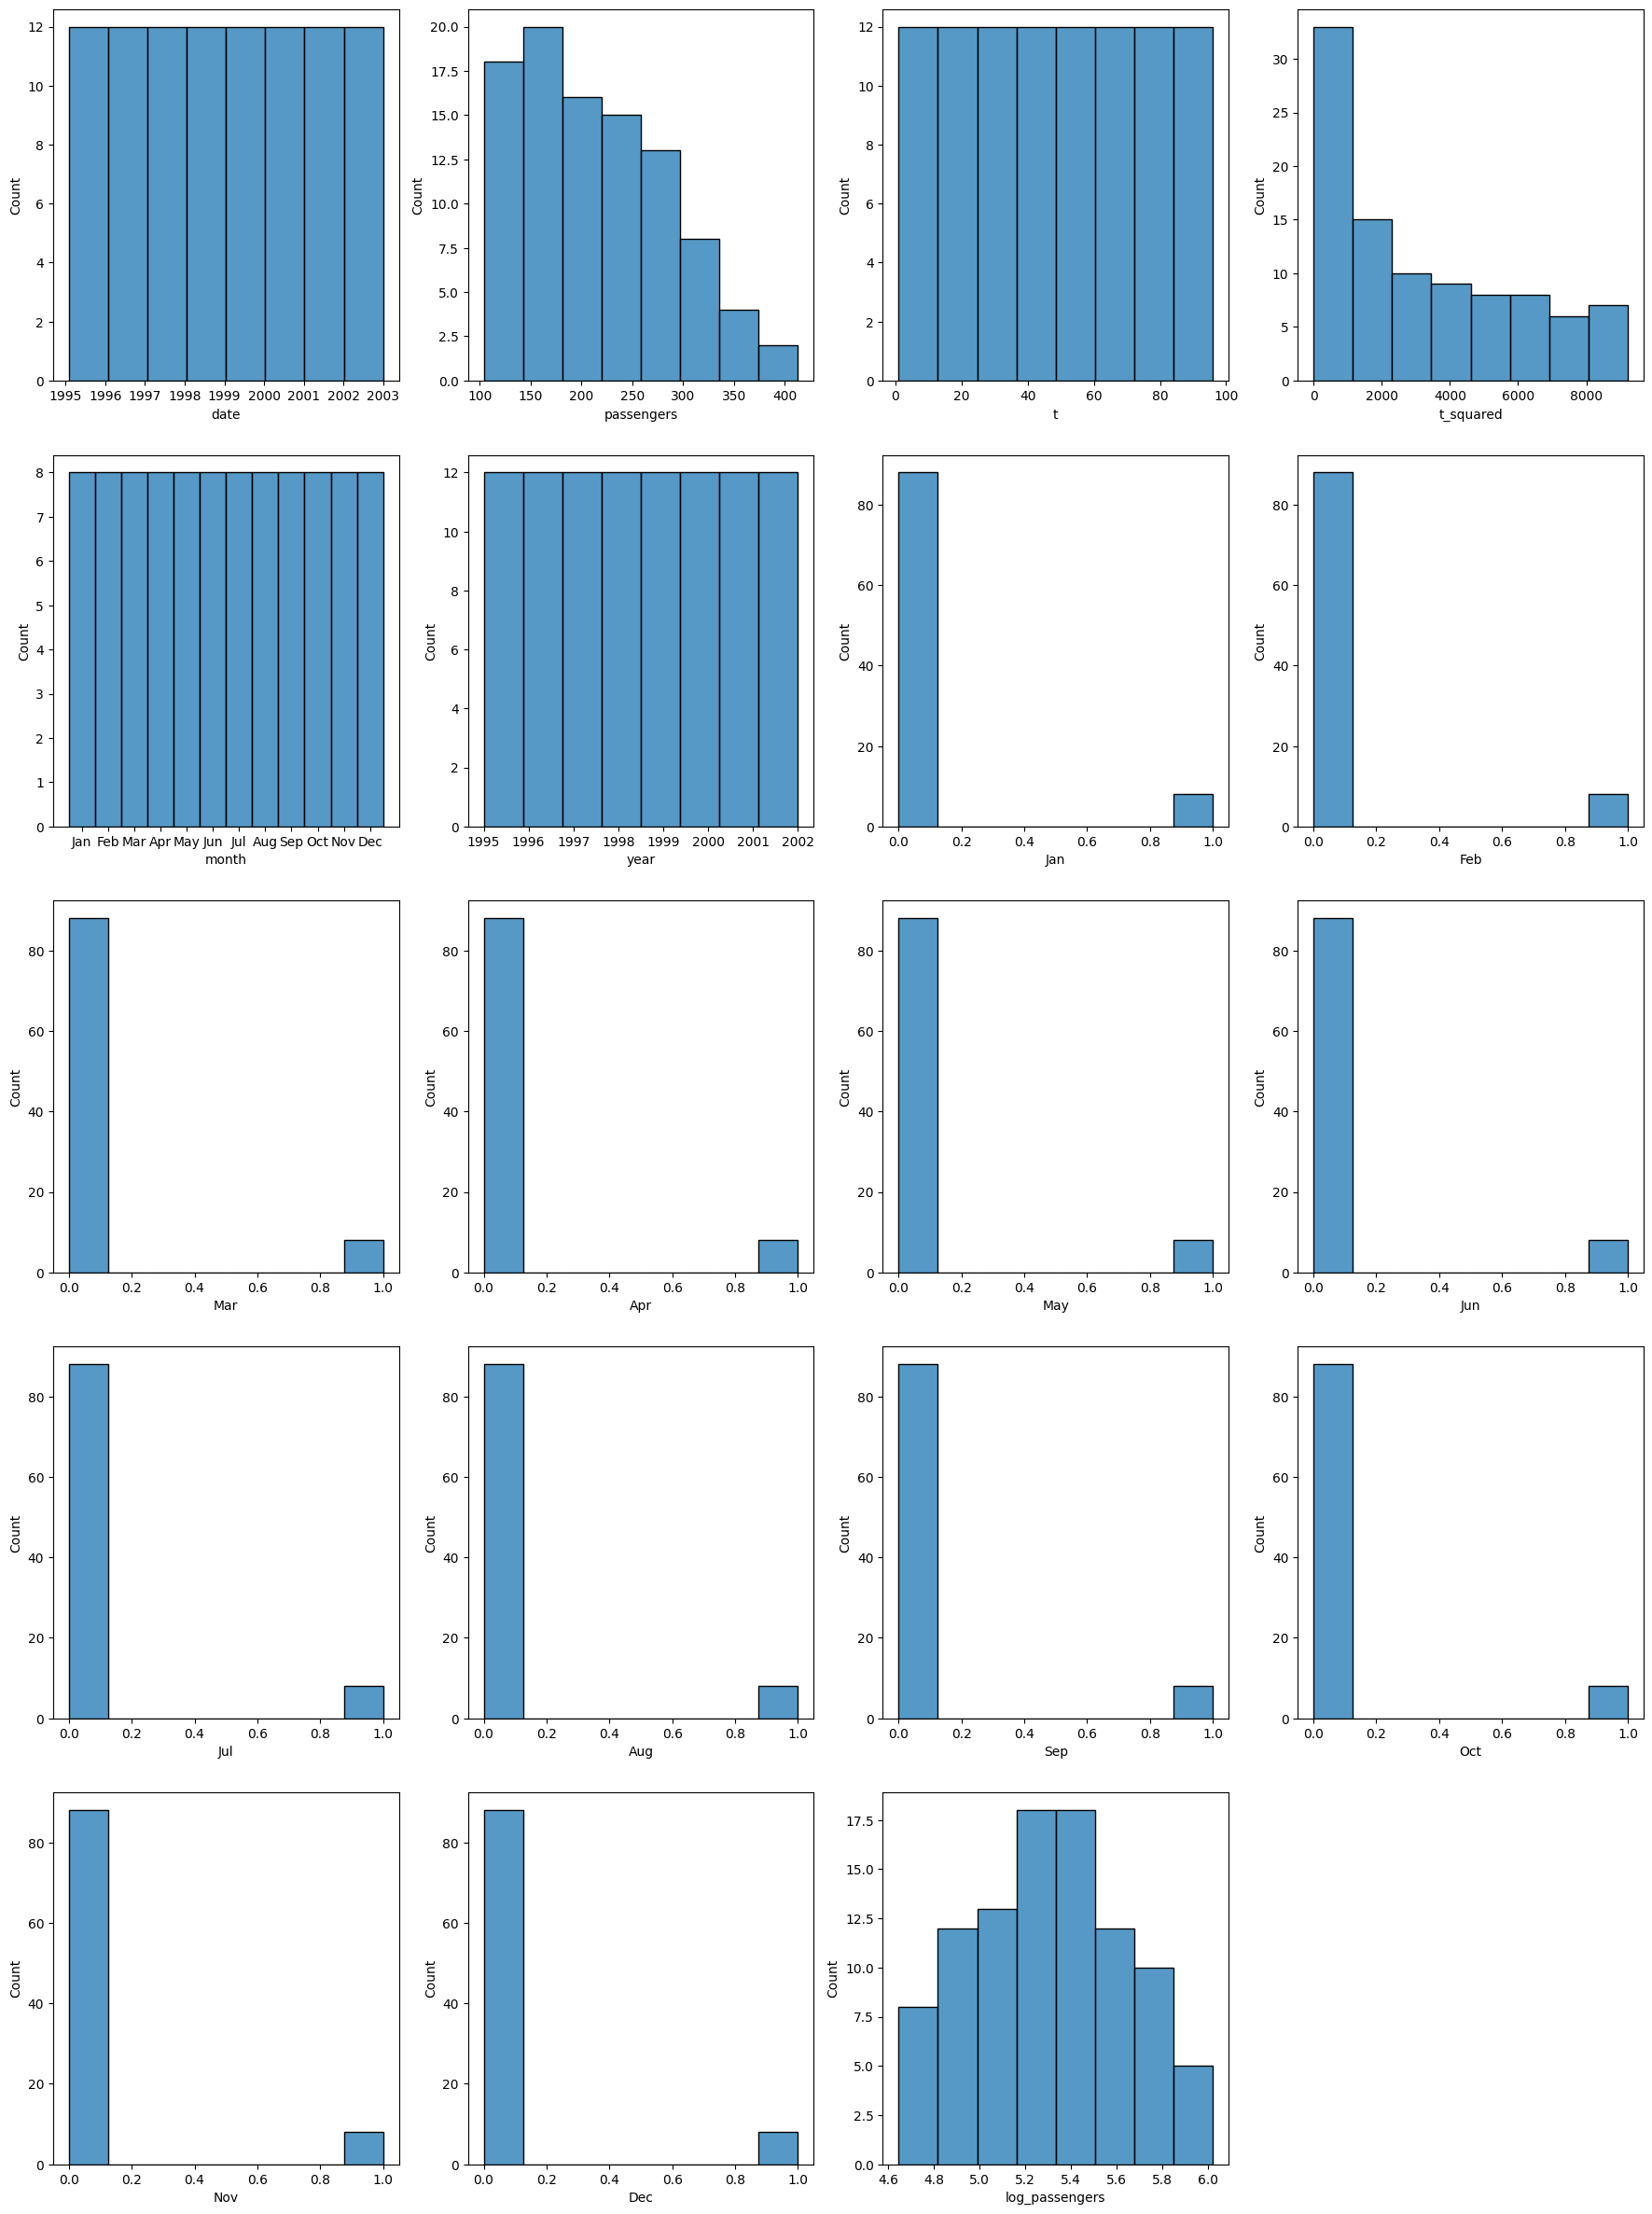

In [ ]:
#plotting histplots to observe datapoints nature
plt.figure(figsize=(22,30))
for i, column in enumerate(airlines_upsp.columns, 1):
    plt.subplot(5,4,i)
    sns.histplot(airlines_upsp[column])

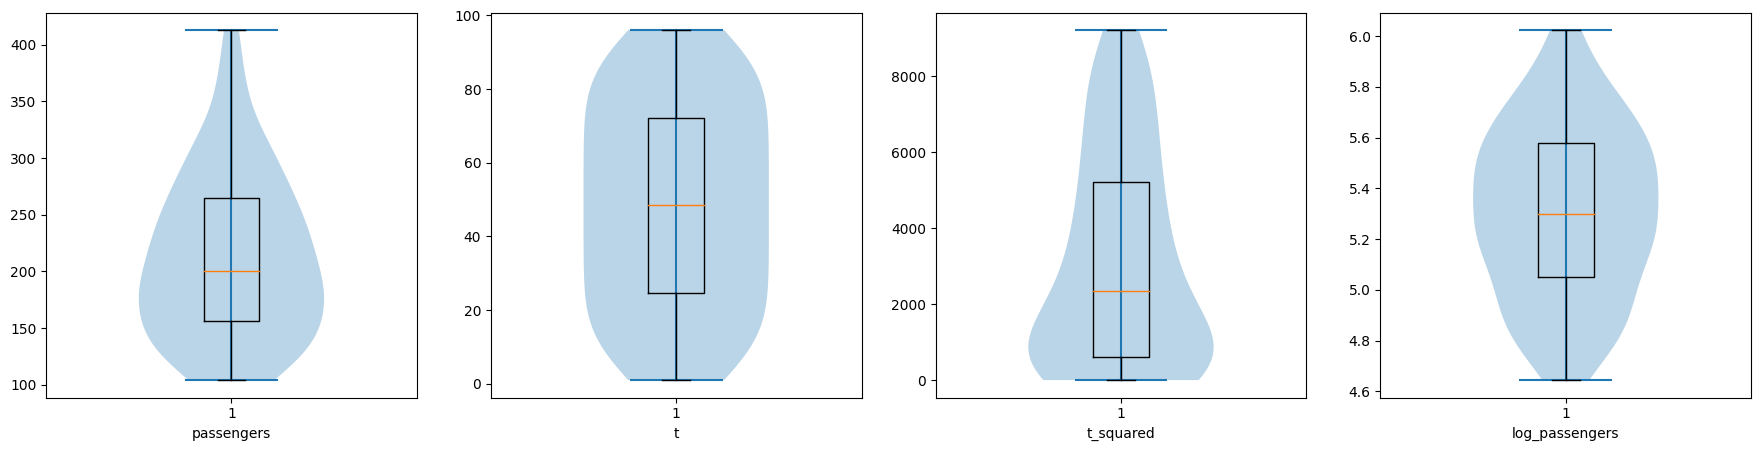

In [ ]:
#plotting boxplots to observe datapoints nature
plt.figure(figsize=(22,5))
for i, column in enumerate(['passengers','t','t_squared','log_passengers'], 1):
    plt.subplot(1,4,i)
    plt.violinplot(airlines_upsp[column])
    plt.boxplot(airlines_upsp[column])
    plt.xlabel(airlines_upsp[column].name)

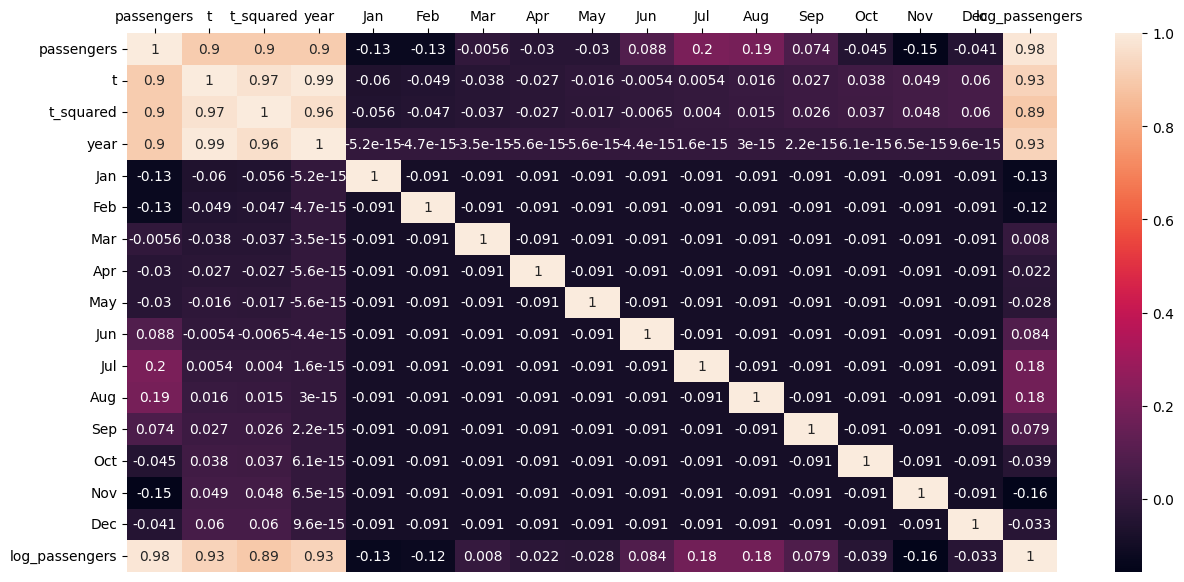

In [ ]:
#plotting the heatmap for correlation
plt.figure(figsize=(15,7))
ax = sns.heatmap(airlines_upsp.corr(), annot=True)
ax.xaxis.tick_top()

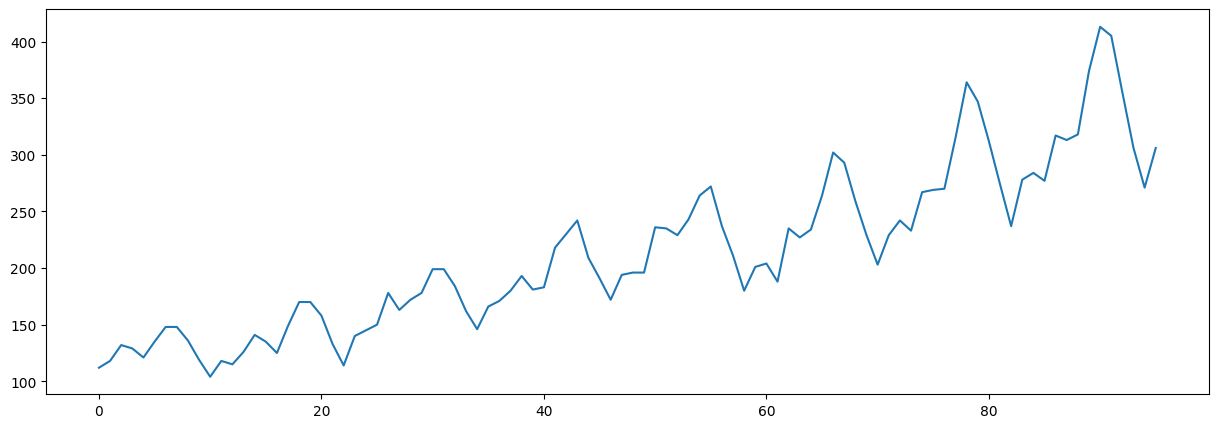

In [ ]:
airlines_upsp['passengers'].plot(figsize=(15, 5))
plt.show()

Moving Average

In [ ]:
airlines_upsp.set_index('date',inplace=True)
airlines_upsp.head()

,passengers,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_passengers
date,,,,,,,,,,,,,,,,,,
1995-01-31,112.0,1,1,Jan,1995,1,0,0,0,0,0,0,0,0,0,0,0,4.718499
1995-02-28,118.0,2,4,Feb,1995,0,1,0,0,0,0,0,0,0,0,0,0,4.770685
1995-03-31,132.0,3,9,Mar,1995,0,0,1,0,0,0,0,0,0,0,0,0,4.882802
1995-04-30,129.0,4,16,Apr,1995,0,0,0,1,0,0,0,0,0,0,0,0,4.859812
1995-05-31,121.0,5,25,May,1995,0,0,0,0,1,0,0,0,0,0,0,0,4.795791


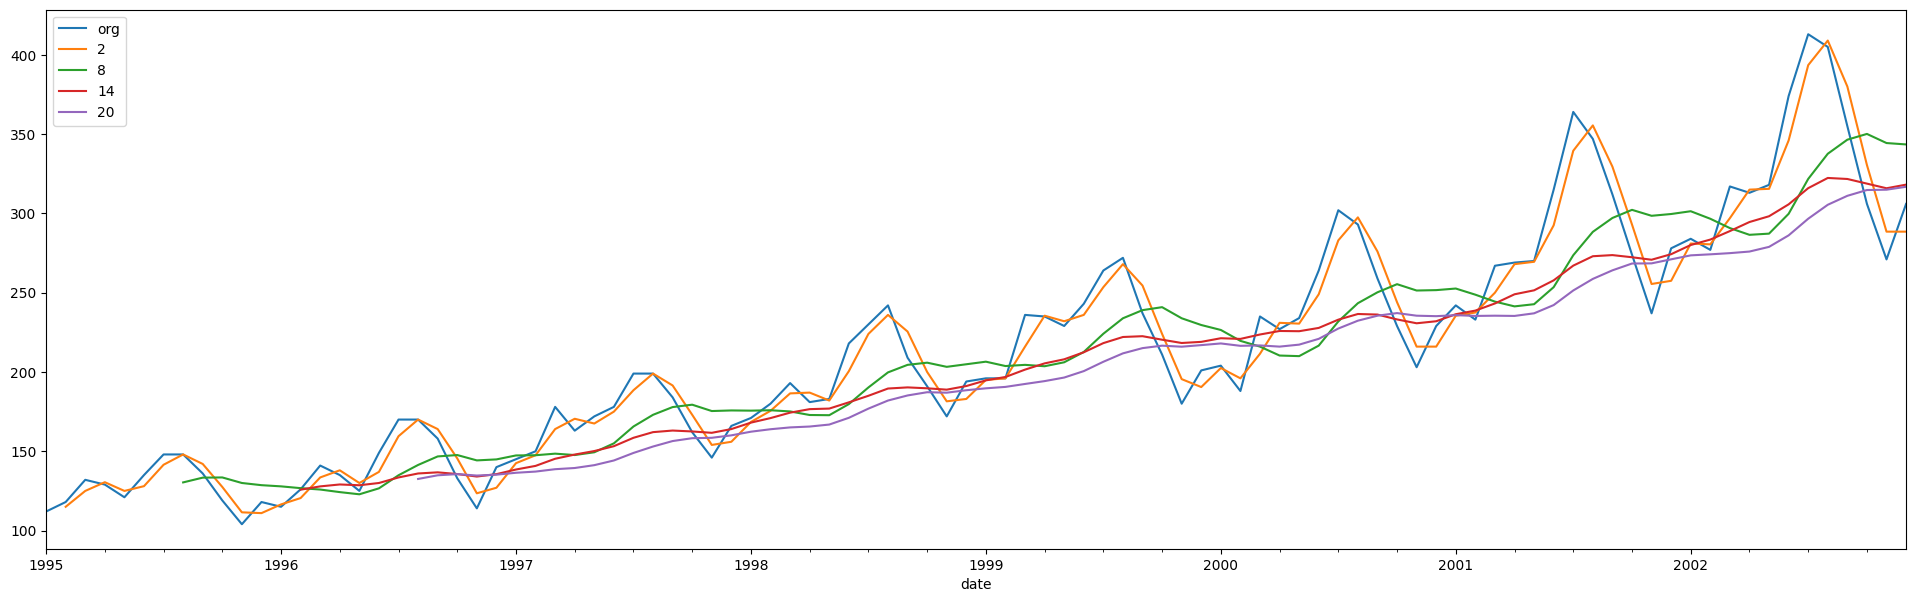

In [ ]:
plt.figure(figsize=(24,7))
airlines_upsp.passengers.plot(label="org")
for i in range(2,24,6):
    airlines_upsp['passengers'].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

Time series decomposition plot

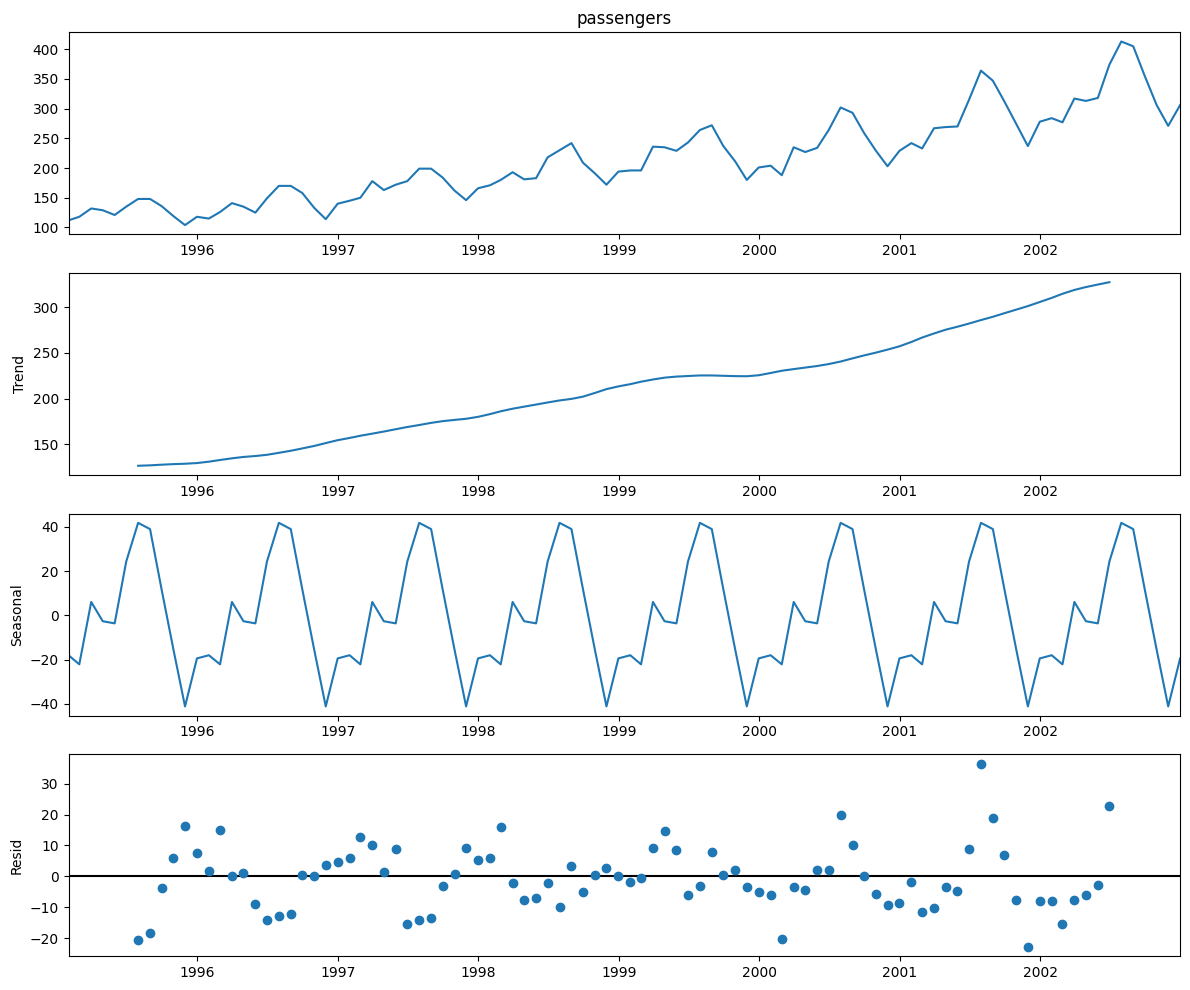

In [ ]:
decompose_ts_add = seasonal_decompose(airlines_upsp.passengers)
with plt.rc_context():
    plt.rc("figure", figsize=(12,10))
    decompose_ts_add.plot()
    plt.show()

ACF plots and PACF plots

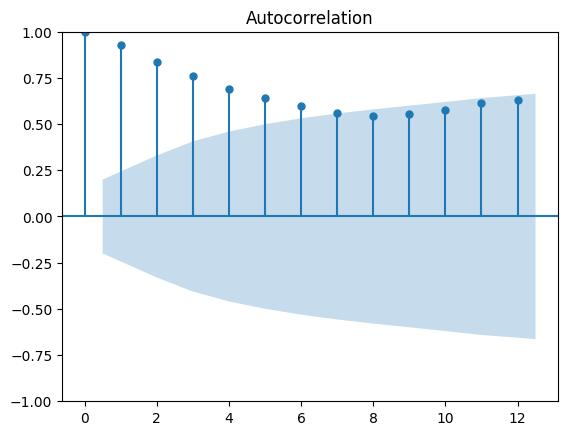

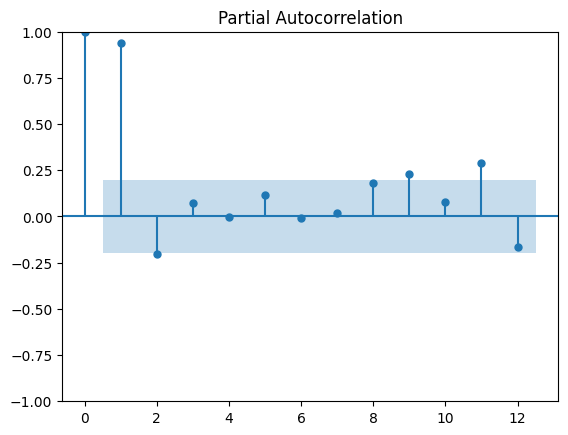

In [ ]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(airlines_upsp.passengers,lags=12)
tsa_plots.plot_pacf(airlines_upsp.passengers,lags=12)
plt.show()

Splitting data

In [ ]:
airlines_upsp.shape

(96, 18)

In [ ]:
Train=airlines_upsp.head(84)
Test=airlines_upsp.tail(12)

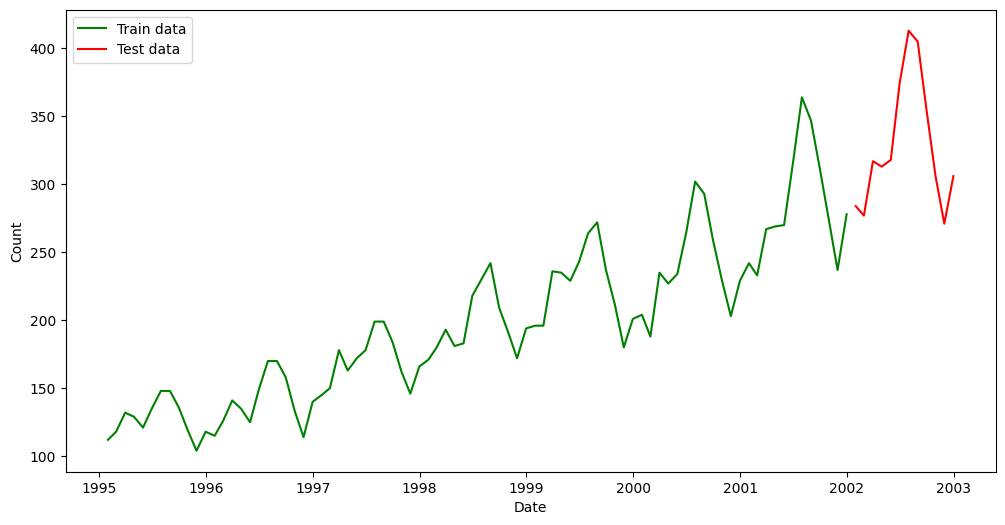

In [ ]:
plt.figure(figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('Count')
plt.plot(Train.passengers, 'green', label='Train data')
plt.plot(Test.passengers, 'red', label='Test data')
plt.legend()
plt.show()

Forecasting_Data_Driven_Models

Evaluation Metric MAPE

In [ ]:
 def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

Simple Exponential Method

In [ ]:
from sklearn.metrics import mean_squared_error
ses_model = SimpleExpSmoothing(Train['passengers']).fit(optimized=True)
test_pred_ses = ses_model.forecast(12)
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = np.sqrt(mean_squared_error(test_pred_ses,Test.passengers))
train_rmse_ses = np.sqrt(mean_squared_error(train_pred_ses,Train.passengers))
mape_ses = MAPE(test_pred_ses,Test.passengers)
print('Simple Exponential Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_ses),"\n",
'Train Root Mean Squared Error = {}'.format(train_rmse_ses),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_ses))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error   = 14.235433154627977 
 Train Root Mean Squared Error = 21.247969155479584 
 Test Root Mean Squared Error  = 68.00674031349585


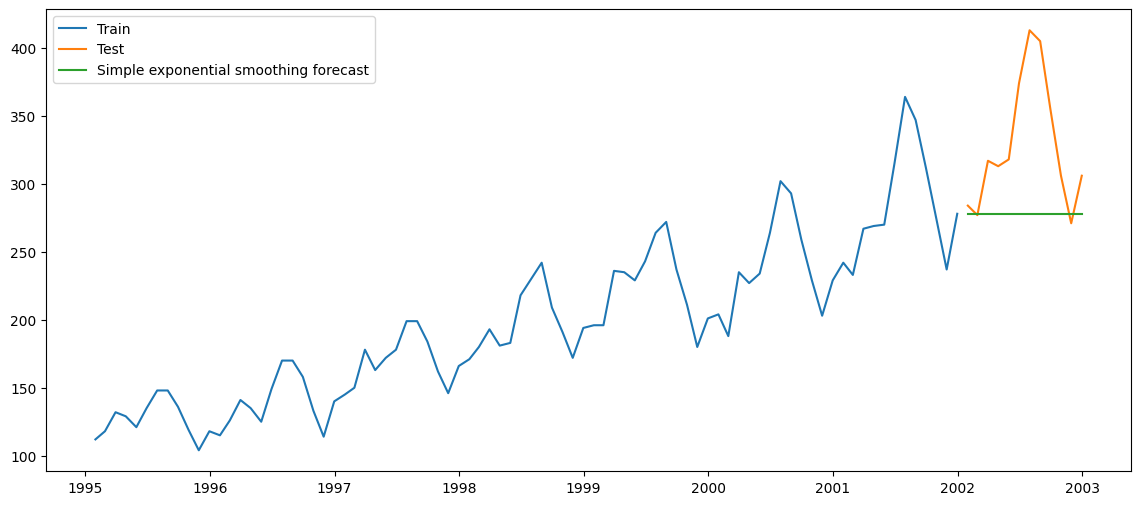

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(Train.passengers, label='Train')
plt.plot(Test.passengers, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.show()

Holt method

In [ ]:
hw_model  = Holt(Train["passengers"]).fit(optimized=True)
test_pred_hw = hw_model.forecast(12)
train_pred_hw = hw_model.fittedvalues
test_rmse_hw = np.sqrt(mean_squared_error(test_pred_hw,Test.passengers))
train_rmse_hw = np.sqrt(mean_squared_error(train_pred_hw,Train.passengers))
mape_hw = MAPE(test_rmse_hw,Test.passengers)
print('Holt Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_hw),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_hw),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_hw))

Holt Method Evaluation 
 Mean Absolute Percent Error   = 81.82504047003955 
 Train Root Mean Squared Error = 21.154758639240143 
 Test Root Mean Squared Error  = 58.57776020000329


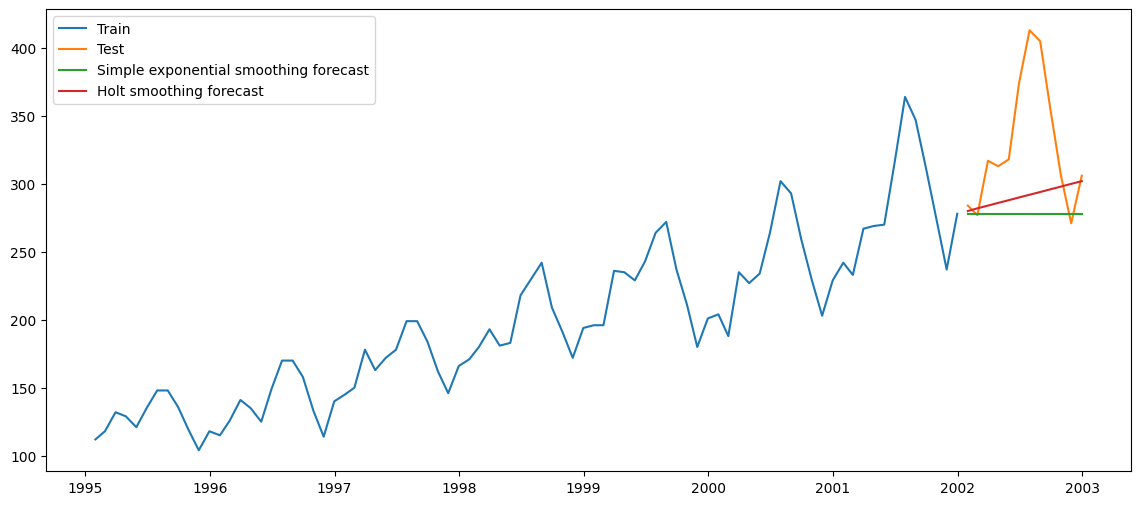

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(Train.passengers, label='Train')
plt.plot(Test.passengers, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.plot(test_pred_hw, label='Holt smoothing forecast')
plt.legend(loc='best')
plt.show()

Holts winter exponential smoothing with additive seasonality and additive trend

In [ ]:
holts_add_model  = ExponentialSmoothing(Train.passengers,seasonal="add",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_hltadd = holts_add_model.forecast(12)
train_pred_hltadd= holts_add_model.fittedvalues
test_rmse_hltadd = np.sqrt(mean_squared_error(test_pred_hltadd,Test.passengers))
train_rmse_hltadd = np.sqrt(mean_squared_error(train_pred_hltadd,Train.passengers))
mape_hltadd = MAPE(test_pred_hltadd,Test.passengers)
print('Holts winter exponential smoothing  with Additive Trend and Seasonality Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_hltadd),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_hltadd),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_hltadd))

Holts winter exponential smoothing  with Additive Trend and Seasonality Method Evaluation 
 Mean Absolute Percent Error   = 5.730704946852847 
 Train Root Mean Squared Error = 9.207292102509339 
 Test Root Mean Squared Error  = 29.590449653925013


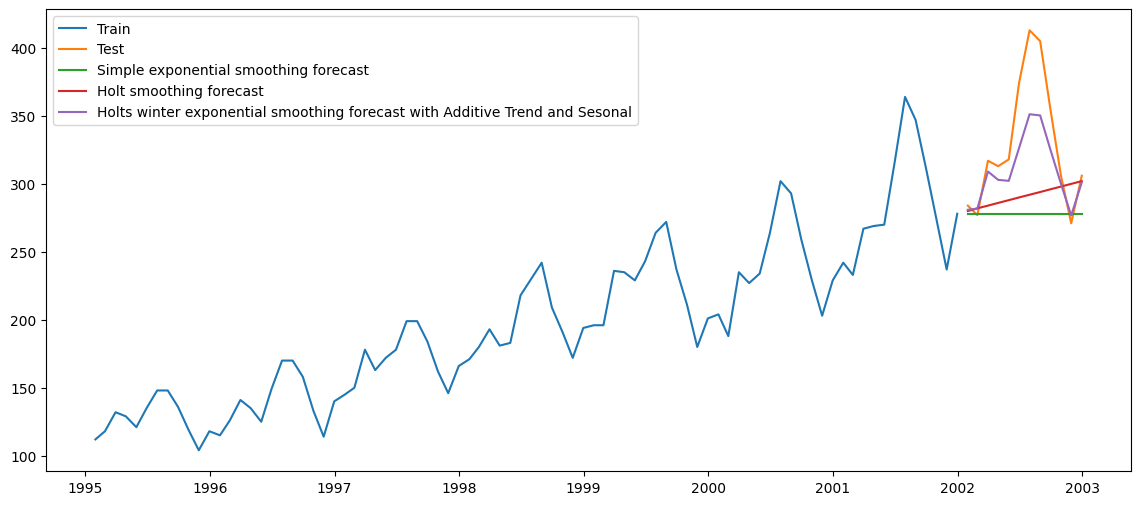

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(Train.passengers, label='Train')
plt.plot(Test.passengers, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.plot(test_pred_hw, label='Holt smoothing forecast')
plt.plot(test_pred_hltadd, label='Holts winter exponential smoothing forecast with Additive Trend and Sesonal')
plt.legend(loc='best')
plt.show()

Holts winter exponential smoothing with add seasonality and multipicative trend

In [ ]:
holts_addmul_model  = ExponentialSmoothing(Train.passengers,seasonal="add",trend="mul",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.5)
test_pred_hltaddmul = holts_addmul_model.forecast(12)
train_pred_hltaddmul= holts_addmul_model.fittedvalues
test_rmse_hltaddmul = np.sqrt(mean_squared_error(test_pred_hltaddmul,Test.passengers))
train_rmse_hltaddmul = np.sqrt(mean_squared_error(train_pred_hltaddmul,Train.passengers))
mape_hltaddmul = MAPE(test_pred_hltaddmul,Test.passengers)
print('Holts winter exponential smoothing  with Additive Trend and multiplicative Seasonality Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_hltaddmul),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_hltaddmul),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_hltaddmul))
     

Holts winter exponential smoothing  with Additive Trend and multiplicative Seasonality Method Evaluation 
 Mean Absolute Percent Error   = 2.3266567386683144 
 Train Root Mean Squared Error = 12.711126425077715 
 Test Root Mean Squared Error  = 11.242795680976029


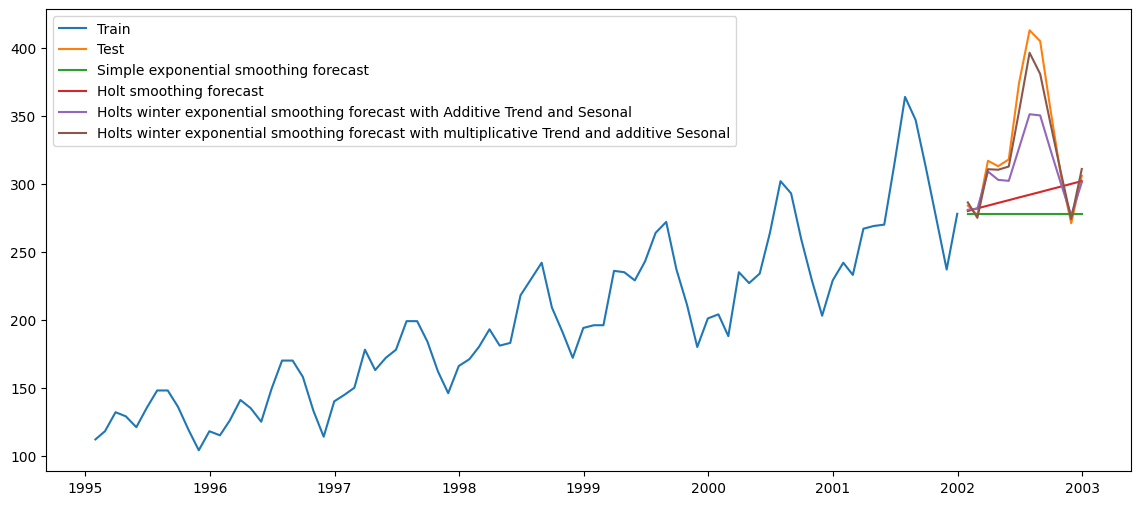

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(Train.passengers, label='Train')
plt.plot(Test.passengers, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.plot(test_pred_hw, label='Holt smoothing forecast')
plt.plot(test_pred_hltadd, label='Holts winter exponential smoothing forecast with Additive Trend and Sesonal')
plt.plot(test_pred_hltaddmul, label='Holts winter exponential smoothing forecast with multiplicative Trend and additive Sesonal')
plt.legend(loc='best')
plt.show()

Holts winter exponential smoothing with multiplicative seasonality and multipicative trend

In [ ]:
holts_muladd_model  = ExponentialSmoothing(Train.passengers,seasonal="mul",trend="add",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.5)
test_pred_hltmuladd = holts_muladd_model.forecast(12)
train_pred_hltmuladd= holts_muladd_model.fittedvalues
test_rmse_hltmuladd = np.sqrt(mean_squared_error(test_pred_hltmuladd,Test.passengers))
train_rmse_hltmuladd = np.sqrt(mean_squared_error(train_pred_hltmuladd,Train.passengers))
mape_hltmuladd = MAPE(test_pred_hltmuladd,Test.passengers)
print('Holts winter exponential smoothing  with Additive Trend and multiplicative Seasonality Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_hltmuladd),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_hltmuladd),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_hltmuladd))

Holts winter exponential smoothing  with Additive Trend and multiplicative Seasonality Method Evaluation 
 Mean Absolute Percent Error   = 6.8144902840755295 
 Train Root Mean Squared Error = 9.81792957491377 
 Test Root Mean Squared Error  = 23.371151514332873


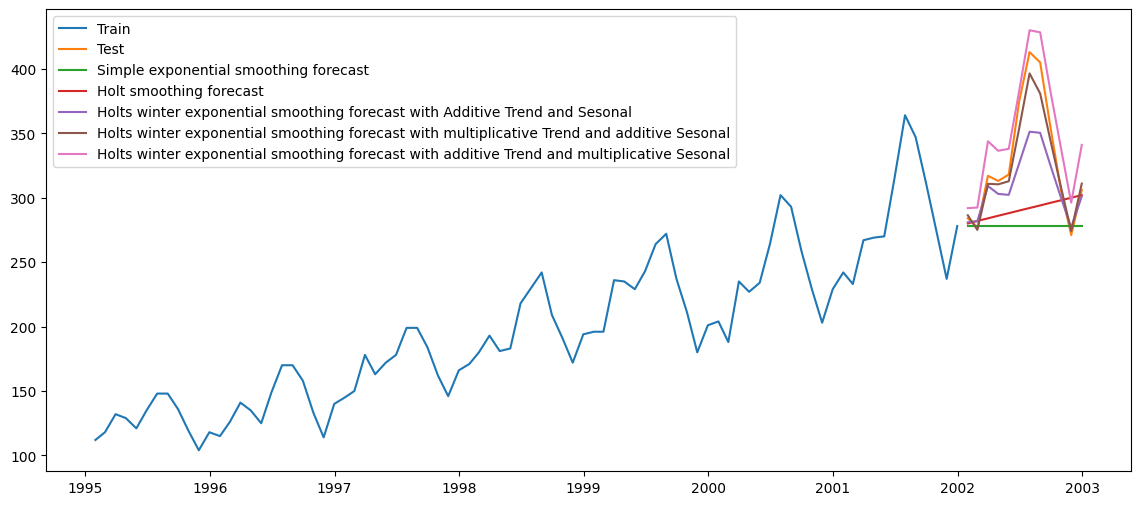

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(Train.passengers, label='Train')
plt.plot(Test.passengers, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.plot(test_pred_hw, label='Holt smoothing forecast')
plt.plot(test_pred_hltadd, label='Holts winter exponential smoothing forecast with Additive Trend and Sesonal')
plt.plot(test_pred_hltaddmul, label='Holts winter exponential smoothing forecast with multiplicative Trend and additive Sesonal')
plt.plot(test_pred_hltmuladd, label='Holts winter exponential smoothing forecast with additive Trend and multiplicative Sesonal')
plt.legend(loc='best')
plt.show()

Holts winter exponential smoothing with multiplicative seasonality and multipicative trend

In [ ]:
holts_mul_model  = ExponentialSmoothing(Train.passengers,seasonal="mul",trend="mul",seasonal_periods=12).fit(optimized=True)
test_pred_hltmul = holts_mul_model.forecast(12)
train_pred_hltmul= holts_mul_model.fittedvalues
test_rmse_hltmul = np.sqrt(mean_squared_error(test_pred_hltmul,Test.passengers))
train_rmse_hltmul = np.sqrt(mean_squared_error(train_pred_hltmul,Train.passengers))
mape_hltmul = MAPE(test_pred_hltmul,Test.passengers)
print('Holts winter exponential smoothing  with Additive Trend and Seasonality Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_hltmul),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_hltmul),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_hltmul))

Holts winter exponential smoothing  with Additive Trend and Seasonality Method Evaluation 
 Mean Absolute Percent Error   = 1.939523551988522 
 Train Root Mean Squared Error = 6.80269660541673 
 Test Root Mean Squared Error  = 7.756832882982536


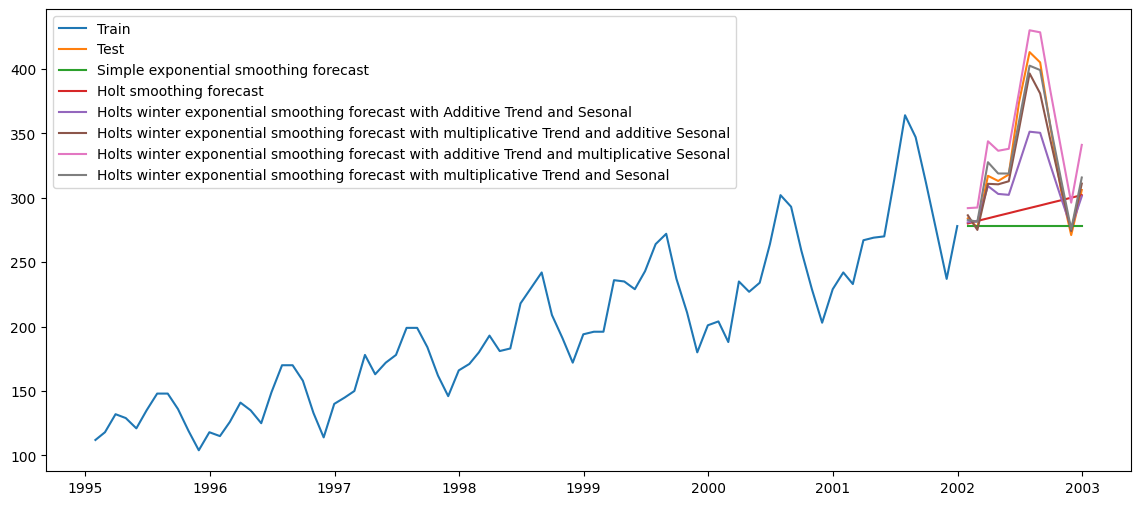

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(Train.passengers, label='Train')
plt.plot(Test.passengers, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.plot(test_pred_hw, label='Holt smoothing forecast')
plt.plot(test_pred_hltadd, label='Holts winter exponential smoothing forecast with Additive Trend and Sesonal')
plt.plot(test_pred_hltaddmul, label='Holts winter exponential smoothing forecast with multiplicative Trend and additive Sesonal')
plt.plot(test_pred_hltmuladd, label='Holts winter exponential smoothing forecast with additive Trend and multiplicative Sesonal')
plt.plot(test_pred_hltmul, label='Holts winter exponential smoothing forecast with multiplicative Trend and Sesonal')
plt.legend(loc='best')
plt.show()

All Models results df

In [ ]:
all_mw = {"Models":pd.Series(["Simple_Exp","holts_exp","Holts_Exp_Add","Holts_exp_addmul","Holts_exp_muladd","Holts_Exp_Mul"]),
        "Test_MAPE(%)":pd.Series(np.round([mape_ses,mape_hw,mape_hltadd,mape_hltaddmul,mape_hltmuladd,mape_hltmul],2)),
        "Train_RMSE":pd.Series(np.round([train_rmse_ses,train_rmse_hw,train_rmse_hltadd,train_rmse_hltaddmul,train_rmse_hltaddmul,train_rmse_hltmul],2)),
        "Test_RMSE_Values":pd.Series(np.round([test_rmse_ses,test_rmse_hw,test_rmse_hltadd,test_rmse_hltaddmul,test_rmse_hltmuladd,test_rmse_hltmul],2))}
table_allmw=pd.DataFrame(all_mw)
table_allmw.sort_values(['Test_RMSE_Values'], inplace=True, ignore_index=True)
table_allmw

,Models,Test_MAPE(%),Train_RMSE,Test_RMSE_Values
0,Holts_Exp_Mul,1.94,6.80,7.76
1,Holts_exp_addmul,2.33,12.71,11.24
2,Holts_exp_muladd,6.81,12.71,23.37
3,Holts_Exp_Add,5.73,9.21,29.59
4,holts_exp,81.83,21.15,58.58
5,Simple_Exp,14.24,21.25,68.01


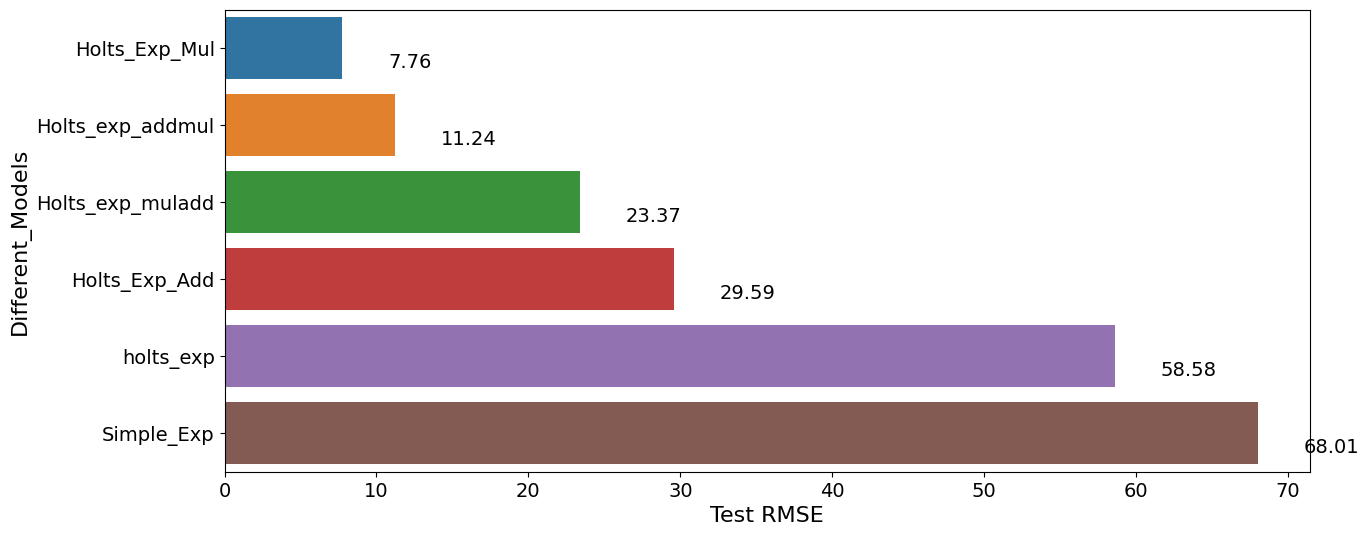

In [ ]:
f, axe = plt.subplots(1,1, figsize=(14,6))
sns.barplot(x='Test_RMSE_Values', y='Models', data=table_allmw, ax = axe)
axe.set_xlabel('Test RMSE', size=16)
axe.set_ylabel('Different_Models', size=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

for i, v in enumerate(table_allmw.Test_RMSE_Values.values):
    axe.text(v + 3, i + .25, str(v), fontsize= 14)
plt.show()

Final Model by combining train and test

In [ ]:
hwe_model_mul = ExponentialSmoothing(Train.passengers,seasonal="mul",trend="mul",seasonal_periods=12).fit(optimized=True)

In [ ]:
#Forecasting for next 12 time periods
hwe_model_mul.forecast(12)

2002-01-31    282.796133
2002-02-28    281.344023
2002-03-31    327.552542
2002-04-30    318.796676
2002-05-31    318.782391
                 ...    
2002-08-31    399.066647
2002-09-30    355.992377
2002-10-31    314.505411
2002-11-30    275.383051
2002-12-31    315.686947
Freq: M, Length: 12, dtype: float64

Forecasting_Model_based_methods

In [ ]:
airlines_upsp

,passengers,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_passengers
date,,,,,,,,,,,,,,,,,,
1995-01-31,112.0,1,1,Jan,1995,1,0,0,0,0,0,0,0,0,0,0,0,4.718499
1995-02-28,118.0,2,4,Feb,1995,0,1,0,0,0,0,0,0,0,0,0,0,4.770685
1995-03-31,132.0,3,9,Mar,1995,0,0,1,0,0,0,0,0,0,0,0,0,4.882802
1995-04-30,129.0,4,16,Apr,1995,0,0,0,1,0,0,0,0,0,0,0,0,4.859812
1995-05-31,121.0,5,25,May,1995,0,0,0,0,1,0,0,0,0,0,0,0,4.795791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002-08-31,405.0,92,8464,Aug,2002,0,0,0,0,0,0,0,1,0,0,0,0,6.003887
2002-09-30,355.0,93,8649,Sep,2002,0,0,0,0,0,0,0,0,1,0,0,0,5.872118
2002-10-31,306.0,94,8836,Oct,2002,0,0,0,0,0,0,0,0,0,1,0,0,5.723585


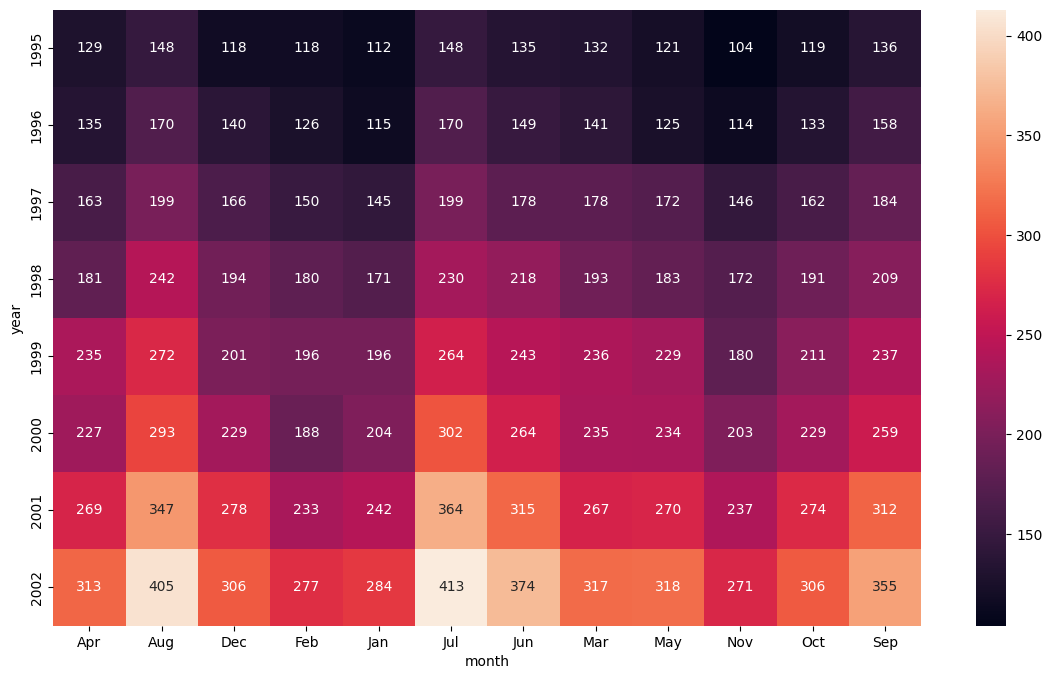

In [ ]:
plt.figure(figsize=(14,8))
heatmap_y_month = pd.pivot_table(data=airlines_upsp,values="passengers",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g")
plt.show()

<Axes: xlabel='year', ylabel='passengers'>

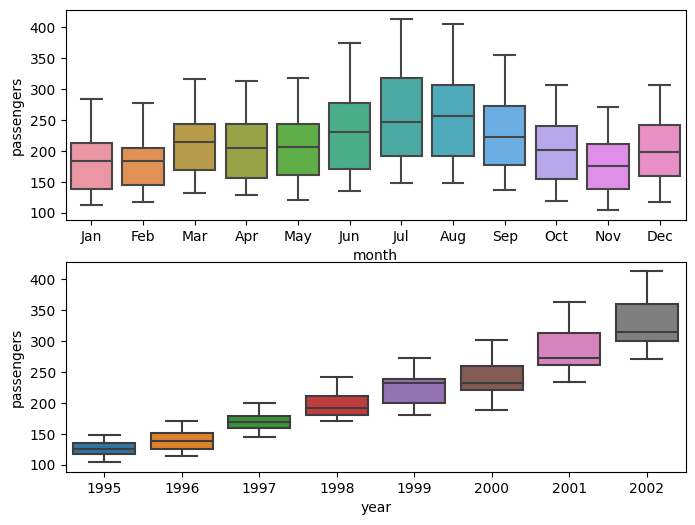

In [ ]:
# box plot for ever
plt.figure(figsize=(8,6))
plt.subplot(211)
sns.boxplot(x='month',y='passengers',data=airlines_upsp)
plt.subplot(212)
sns.boxplot(x='year',y='passengers',data=airlines_upsp)

<Axes: xlabel='year', ylabel='passengers'>

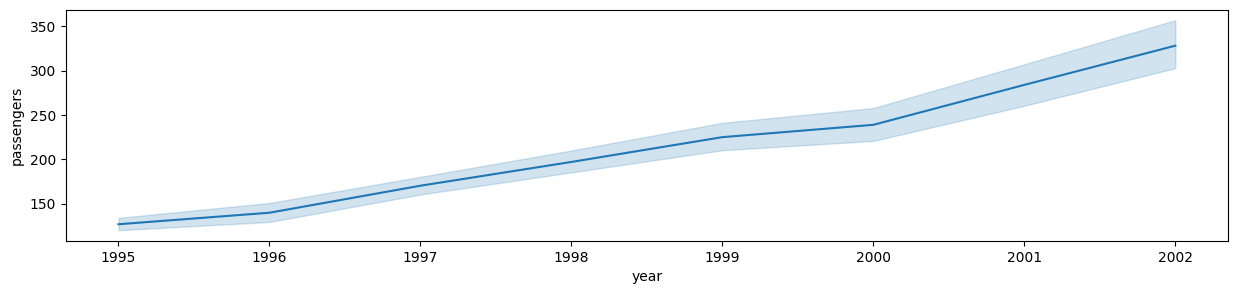

In [ ]:
plt.figure(figsize=(15,3))
sns.lineplot(x='year',y='passengers',data=airlines_upsp)

In [ ]:
Train=airlines_upsp.head(84)
Test=airlines_upsp.tail(12)
Test

,passengers,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_passengers
date,,,,,,,,,,,,,,,,,,
2002-01-31,284.0,85,7225,Jan,2002,1,0,0,0,0,0,0,0,0,0,0,0,5.648974
2002-02-28,277.0,86,7396,Feb,2002,0,1,0,0,0,0,0,0,0,0,0,0,5.624018
2002-03-31,317.0,87,7569,Mar,2002,0,0,1,0,0,0,0,0,0,0,0,0,5.758902
2002-04-30,313.0,88,7744,Apr,2002,0,0,0,1,0,0,0,0,0,0,0,0,5.746203
2002-05-31,318.0,89,7921,May,2002,0,0,0,0,1,0,0,0,0,0,0,0,5.762051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002-08-31,405.0,92,8464,Aug,2002,0,0,0,0,0,0,0,1,0,0,0,0,6.003887
2002-09-30,355.0,93,8649,Sep,2002,0,0,0,0,0,0,0,0,1,0,0,0,5.872118
2002-10-31,306.0,94,8836,Oct,2002,0,0,0,0,0,0,0,0,0,1,0,0,5.723585


i)Linear model

In [ ]:
import statsmodels.formula.api as smf
linear_model=smf.ols('passengers~t',data=Train).fit()
pred_linear=pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rsme_linear=np.sqrt(np.mean((np.array(Test['passengers'])-np.array(pred_linear))**2))
rsme_linear

53.19923653480278

ii)Exponential Model

In [ ]:
Exp = smf.ols('log_passengers~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['passengers'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

46.05736110315654

iii)Quadratic Model

In [ ]:
Quad = smf.ols('passengers~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['passengers'])-np.array(pred_Quad))**2))
rmse_Quad

48.05188897933164

iv)Additive seasonality

In [ ]:
add_sea = smf.ols('passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['passengers'])-np.array(pred_add_sea))**2))
rmse_add_sea

132.8197848142182

v)Additive Seasonality Quadratic

In [ ]:
add_sea_Quad = smf.ols('passengers~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['passengers'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

26.360817612095307

vii)Multiplicative Additive Seasonality

In [ ]:
Mul_Add_sea = smf.ols('log_passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['passengers'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea 

10.519172544323746

ARIMA Hyperparameters